In [4]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, accuracy_score, plot_roc_curve, plot_confusion_matrix, roc_curve, confusion_matrix
import itertools
from tensorflow.keras.initializers import Constant, TruncatedNormal
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from numpy import mean, absolute

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [5]:
infile = open('../01_prognosemodell/06_newtry/fairness_ready.pkl','rb')
df = pickle.load(infile)
infile.close()

df_demo = df[['UebungsID','Buecher']]
df_demo = df_demo.drop_duplicates()

In [6]:
n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]

for i in n:
    path='../01_prognosemodell/06_newtry/matrices_allsessions/matrix'+str(i)+'.pkl'
    infile = open(path,'rb')
    df = pickle.load(infile)
    infile.close()
    df = df.reset_index(level=0)
    df = pd.merge(df, df_demo, how='left')

    df['Buecher'] = df['Buecher'].replace(['10'],0)
    df['Buecher'] = df['Buecher'].replace(['200'],1)
    df_0 = df[df.Buecher == 0.0]
    df_1 = df[df.Buecher == 1]

    df = pd.concat([df_0,df_1]) 
    df.Buecher = df.Buecher.astype('float')

    # Randomly over sample the minority class
    X_df = df.drop(columns=['Buecher'])
    y_df = df.Buecher
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote= smote.fit_resample(X_df, y_df)
    df = X_train_smote.join(pd.DataFrame(list(y_train_smote.values), columns=['Buecher']))


    path = 'buecher_allsessions/matrix'+ str(i) +'.pkl'
    df.to_pickle(path)

Models

In [7]:
metrics = pd.DataFrame(columns=['model', 'group', 'subgroup','Length', 'Sentence', 'Accuracy','max_depth', 'min_samples_leaf', 'min_samples_split', 'Precision', 'Recall', 'AUC', 'FPR'])

In [8]:
def get_metrics(clf,X,y,cv,pred):
    a = accuracy_score(y,pred)
    p = precision_score(y,pred)
    r = recall_score(y,pred)

    roc_auc = roc_auc_score(y,pred)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    fpr = fp/(fp+tn)

    return a,p,r,roc_auc,fpr

In [9]:
max_depth = [1,5,10,15,20,25,5,5,5,5,5,5,5,5,5,5,5,5]
min_samples_leaf = [1,1,1,1,1,1,1,5,10,15,20,25,1,1,1,1,1,1]
min_samples_split = [2,2,2,2,2,2,2,2,2,2,2,2,2,5,10,15,20,25]

for (max_depth, min_samples_leaf, min_samples_split) in zip(max_depth, min_samples_leaf, min_samples_split):
    n = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
    feature_cols = ['Erstloesung','Schussel','Erfolg', 'Schwierigkeit', 'ist_Schulzeit', 'MehrfachFalsch', 'vorher_abgebrochen','Fehler', 'Klassenstufe', 'Jahredabei', 'AnzahlAufgaben', 'Sex__m', 'Sex__w', 'Testposition__pruefung', 'Testposition__training','Testposition__version', 'Art__GK', 'Art__GR', 'Art__GZ', 'Art__K', 'Art__LB','UserAttribut', 'OrderNumber', 'steps']
        
    for i in n:
        #build models
        path='buecher_allsessions/matrix'+str(i)+'.pkl'
        infile = open(path,'rb')
        df = pickle.load(infile)
        infile.close()
        df=df.reset_index()
        X = df[feature_cols]
        y = df.y
        y= y.astype('int')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        k = 5
        cv = KFold(n_splits=k, random_state=None)

        #DTE
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth,min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        clf = clf.fit(X_train,y_train)
        pred = clf.predict(X_test)

        a,p,r,roc_auc,fpr = get_metrics(clf,X_test,y_test,cv,pred)

        metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

        group = ['buecher', 'buecher']
        subgroup = ['buch0', 'buch1']
        matrice = ['matrices_buecher_0', 'matrices_buecher_1']

        for (group, subgroup, matrix) in zip(group, subgroup, matrice):
            path= '../01_prognosemodell/06_newtry/'+matrix+'/matrix'+str(i)+'.pkl'
            infile = open(path,'rb')
            df = pickle.load(infile)
            infile.close()
            df=df.reset_index()
            X = df[feature_cols]
            y = df.y
            y= y.astype('int')
            pred = clf.predict(X)
            
            a,p,r,roc_auc,fpr = get_metrics(clf,X,y,cv,pred)
            metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)

C:\Users\Nathalie\AppData\Local\Temp\ipykernel_22904\3809603786.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':'all','subgroup':'all','Length':len(df),'Sentence': i, 'Accuracy':a,'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\Nathalie\AppData\Local\Temp\ipykernel_22904\3809603786.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'model':'DTE','group':group,'subgroup':subgroup,'Length':len(df),'Sentence': i, 'Accuracy':a,'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split,'Precision': p, 'Recall':r, 'AUC':roc_auc, 'FPR':fpr}, ignore_index=True)
C:\Users\

Evaluate

In [10]:
df = metrics
grouped = df.groupby(df.group)
df_buecher = grouped.get_group("buecher")

df_buecher = df_buecher.drop(columns=['group', 'Accuracy'])
df_buecher = pd.pivot_table(df_buecher, values=["Precision","Recall","AUC","FPR"], index=['max_depth', 'min_samples_leaf', 'min_samples_split', "Sentence"], columns=["subgroup"])
df_buecher['PP'] = df_buecher.Precision.buch1-df_buecher.Precision.buch0
df_buecher['EO'] = df_buecher.Recall.buch0-df_buecher.Recall.buch1
df_buecher['SA'] = df_buecher.AUC.buch1-df_buecher.AUC.buch0
df_buecher['PE'] = df_buecher.FPR.buch0-df_buecher.FPR.buch1
df_buecher = df_buecher.drop(columns=['AUC','Precision','Recall','FPR'])
df_buecher.columns = df_buecher.columns.droplevel(1)
df_buecher = pd.pivot_table(df_buecher, values=["PP","EO","SA","PE"], index=["Sentence"], columns=['max_depth', 'min_samples_leaf', 'min_samples_split'])


In [11]:
test = df_buecher
met = ['EO','PE','PP','SA']
fertig = pd.DataFrame()

max_depth = [1,5,10,15,20,25,5,5,5,5,5,5,5,5,5,5,5,5]
min_samples_leaf = [1,1,1,1,1,1,1,5,10,15,20,25,1,1,1,1,1,1]
min_samples_split = [2,2,2,2,2,2,2,2,2,2,2,2,2,5,10,15,20,25]

for (max_depth, min_samples_leaf, min_samples_split) in zip(max_depth, min_samples_leaf, min_samples_split):

    for x in met: 
        a=0
        for i in range(2, 10):
            a = a+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        a = a/8
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '02-9',
                'Val': a,
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])

        b = 0
        for i in range(10, 20):
            b = b+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        b = b/9
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '10-19',
                'Val': b,             
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])

        c = 0
        for i in range(20, 30):
            c = c+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        c = c/9
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '20-29',
                'Val': c,
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])

        d = 0
        for i in range(30, 40):
            d = d+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        d = d/9
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '30-39',
                'Val': d,
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])

        e = 0
        for i in range(40, 50):
            e = e+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        e = e/9
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '40-49',
                'Val': e,
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])

        f = 0
        for i in range(50, 60):
            f = f+test[x][max_depth][min_samples_leaf][min_samples_split][i]
        f = f/10
        temp = pd.DataFrame(
            {
                'Metrik':[x],
                'Model': 'DTE',
                'Range': '50-60',
                'Val': f,
                'max_depth':max_depth,
                'min_samples_leaf':min_samples_leaf,
                'min_samples_split':min_samples_split
            }
        )
        fertig = pd.concat([fertig, temp])


In [12]:
#format result

def threshold001(v, props=''):
    return props if (v > 0.02) or (v < -0.02) else None

def threshold005(v, props=''):
    return props if (v > 0.05) or (v < -0.05) else None

def negativeValue(v, props=''):
    return props if (v < 0) else None

def showTable(df):
    styled = df.style.set_properties(color="black", align="right")\
        .set_properties(**{'background-color': 'white'})\
        .applymap(threshold001, props='color:orange;')\
        .applymap(threshold005, props='color:red;')\
        .applymap(negativeValue, props='font-weight:bold;')
    return styled

In [13]:
mean_table = pd.pivot_table(fertig, values=['Val'], index=['max_depth', 'min_samples_leaf', 'min_samples_split','Range'], columns=['Metrik','Model'])
showTable(mean_table)

In [14]:
grouped = metrics.groupby(metrics.group)
df_all = grouped.get_group("all")
modell = df_all.groupby(df_all.max_depth)
five = modell.get_group(1)
n = five.groupby(five.min_samples_leaf)
n = n.get_group(1)
f = n.groupby(n.min_samples_split)
f = f.get_group(2)

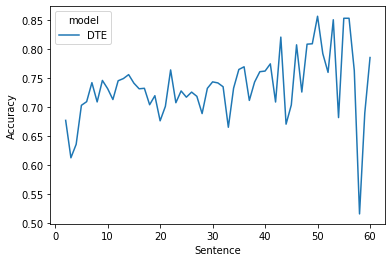

In [15]:
ax = sns.lineplot(data=f, x='Sentence', y='Accuracy', hue='model')